In [2]:
from PIL import Image
import numpy as np
import matplotlib.image as img
import os
import time
import glob
import re
import matplotlib.pyplot as plt
import random
import seaborn as sns
from scipy.fftpack import dct ,idct
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.manifold import Isomap, TSNE
from scipy.spatial.distance import cdist
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import pandas as pd

In [3]:
#This data set is a reduced version of the MNIST dataset with 10000 training examples(1000 examples for each digit)
#and 2000 test examples (200 test examples for each digit)

#prepare train and test datasets for extracting features and classifing
train_folder='drive/MyDrive/Reduced MNIST Data/Reduced Trainging data';
test_folder='drive/MyDrive/Reduced MNIST Data/Reduced Testing data';
train_images_names=[];
test_images_names=[];

In [4]:
for i in range(10):
    # two lists of all training,testing images names
    train_images_names.append(glob.glob('{}/{}/*.jpg'.format(train_folder,i)))
    test_images_names.append(glob.glob('{}/{}/*.jpg'.format(test_folder,i)))

# Expanding sublists into one list
train_images_names = [item for sublist in train_images_names for item in sublist];
test_images_names = [item for sublist in test_images_names for item in sublist];
#training , test data from lists
train_dataset = np.array([np.array(Image.open(fname)) for fname in train_images_names])
test_dataset = np.array([np.array(Image.open(fname)) for fname in test_images_names])


In [5]:
# Adding a label coressponding each training and testing example
train_label=np.array([list(map(int, re.findall(r'\b\d\b', fname)))[0]  for fname in train_images_names])
test_label=np.array([list(map(int, re.findall(r'\b\d\b', fname)))[0]  for fname in test_images_names])

# Shuffling the training ,test data
# Normalizing data for faster convergence
train_dataset,train_label = shuffle(train_dataset/255, train_label)
test_dataset,test_label = shuffle(test_dataset/255, test_label)

In [6]:
# checking sizes of train and test data
print("training data shape is ",train_dataset.shape)
print("Test data shape is ",test_dataset.shape)

# checking the min and max of train data after normalization
print("The min value of a pixel after normalization",train_dataset.min())
print("The max value of a pixel after normalization",train_dataset.max())

# Functions used to extract DCT features
# 2-D DCT feature extractor
def dct2(a):
    return dct(dct(a.T, norm='ortho').T, norm='ortho')

#zigzag of DCT taking only first 200 elements
def zigzag(a):
    x=np.concatenate([np.diagonal(a[::-1,:], i)[::(2*(i % 2)-1)] for i in range(1-a.shape[0], a.shape[0])])
    return x[0:200]


training data shape is  (10000, 28, 28)
Test data shape is  (2000, 28, 28)
The min value of a pixel after normalization 0.0
The max value of a pixel after normalization 1.0


# **DCT**

In [7]:
# 2-D inverse DCT
def idct2(a):
    return idct(idct(a.T, norm='ortho').T, norm='ortho')

def get_dct_features(a):
    ''' Computes DCT features for all examples of training data
    :a: training data
    :DCT_ordered: DCT features for a single image in zigzag order
    :DCT_features: DCT feature of all training examples in zigzag order'''
    DCT_features=np.zeros((a.shape[0],200))

    for i in range(a.shape[0]):
        DCT_ordered=zigzag(dct2(a[i]))
        DCT_features[i] = DCT_ordered
    return DCT_features.reshape((a.shape[0],-1))

DCT_features_train=get_dct_features(train_dataset)
print("The DCT features for training are now of size {} using DCT coffecients ".format(DCT_features_train.shape))
DCT_features_test=get_dct_features(test_dataset)
print("The DCT features for testing are now of size {} using DCT coffecients ".format(DCT_features_test.shape))


The DCT features for training are now of size (10000, 200) using DCT coffecients 
The DCT features for testing are now of size (2000, 200) using DCT coffecients 


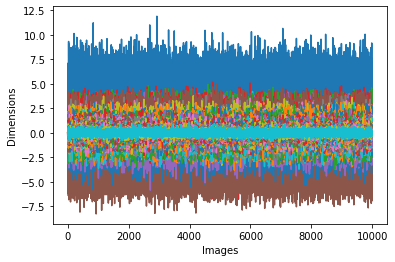

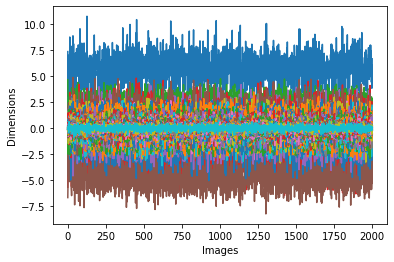

In [8]:
plt.plot(DCT_features_train)
plt.ylabel('Dimensions')
plt.xlabel('Images')
plt.savefig("DCT_features_train.png")
plt.show()

plt.plot(DCT_features_test)
plt.ylabel('Dimensions')
plt.xlabel('Images')
plt.savefig("DCT_features_test.png")
plt.show()

In [9]:
f5 = open("drive/MyDrive/dct_train.txt", 'w')
f6 = open("drive/MyDrive/dct_test.txt", 'w')
f5.write("[")
for i in range(DCT_features_train.shape[0]):
    f5.write("[")
    for k in range(DCT_features_train.shape[1]):
        f5.write(str(DCT_features_train[i][k]))
        f5.write(" ")
    f5.write("]\n")
f5.write("]")

f6.write("[")
for i in range(DCT_features_test.shape[0]):
    f6.write("[")
    for k in range(DCT_features_test.shape[1]):
        f6.write(str(DCT_features_test[i][k]))
        f6.write(" ")
    f6.write("]\n")
f6.write("]")

1

# **PCA**

In [10]:
# PCA such the 90% of the variance is retained
pca = PCA(0.90)
pca.fit(train_dataset.reshape((train_dataset.shape[0],784)))
train_pca = pca.transform(train_dataset.reshape((train_dataset.shape[0],784)))
test_pca = pca.transform(test_dataset.reshape((test_dataset.shape[0],784)))
print("The components number for 90% varinace is ",pca.n_components_)


The components number for 90% varinace is  167


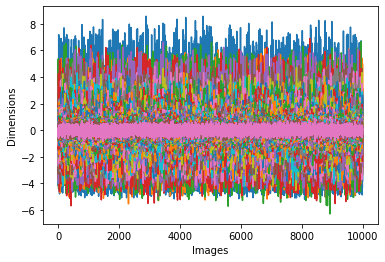

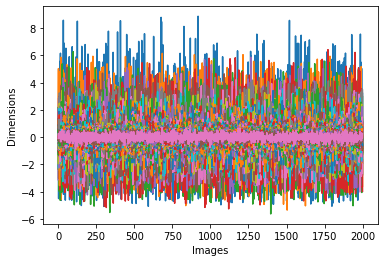

In [11]:
plt.plot(train_pca)
plt.ylabel('Dimensions')
plt.xlabel('Images')
plt.savefig("PCA_features_train.png")
plt.show()

plt.plot(test_pca)
plt.ylabel('Dimensions')
plt.xlabel('Images')
plt.savefig("PCA_features_test.png")
plt.show()

In [12]:
f = open("drive/MyDrive/pca_train.txt", 'w')
f2 = open("drive/MyDrive/pca_test.txt", 'w')
f.write("[")
for i in range(train_pca.shape[0]):
    f.write("[")
    for k in range(train_pca.shape[1]):
        f.write(str(train_pca[i][k]))
        f.write(" ")
    f.write("]\n")
f.write("]")

f2.write("[")
for i in range(test_pca.shape[0]):
    f2.write("[")
    for k in range(test_pca.shape[1]):
        f2.write(str(test_pca[i][k]))
        f2.write(" ")
    f2.write("]\n")
f2.write("]")



1

# **LDA**

In [13]:

lda = LDA(n_components=8)#Number of components (<= min(n_classes - 1, n_features)) for dimensionality reduction.
lda_train = lda.fit_transform(train_dataset.reshape((train_dataset.shape[0],784)), train_label)
lda_test = lda.transform(test_dataset.reshape((test_dataset.shape[0],784)))


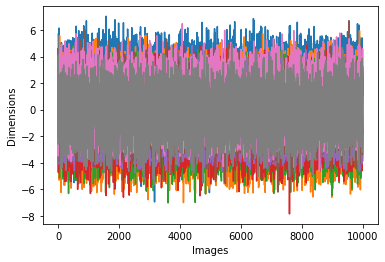

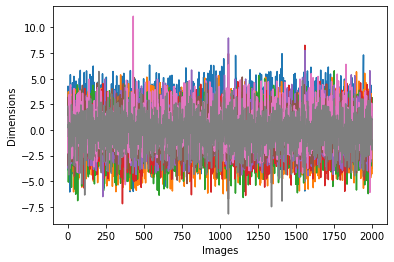

In [14]:
plt.plot(lda_train)
plt.ylabel('Dimensions')
plt.xlabel('Images')
plt.savefig("LDA_features_train.png")
plt.show()

plt.plot(lda_test)
plt.ylabel('Dimensions')
plt.xlabel('Images')
plt.savefig("LDA_features_test.png")
plt.show()

In [15]:
f3 = open("drive/MyDrive/lda_train.txt", 'w')
f4 = open("drive/MyDrive/lda_test.txt", 'w')
f3.write("[")
for i in range(lda_train.shape[0]):
    f3.write("[")
    for k in range(lda_train.shape[1]):
        f3.write(str(lda_train[i][k]))
        f3.write(" ")
    f3.write("]\n")
f3.write("]")

f4.write("[")
for i in range(lda_test.shape[0]):
    f4.write("[")
    for k in range(lda_test.shape[1]):
        f4.write(str(lda_test[i][k]))
        f4.write(" ")
    f4.write("]\n")
f4.write("]")

1

In [16]:
print("The LDA features for training are now of size {} using DCT coffecients ".format(lda_train.shape))
print("The LDA features for testing are now of size {} using DCT coffecients ".format(lda_test.shape))

The LDA features for training are now of size (10000, 8) using DCT coffecients 
The LDA features for testing are now of size (2000, 8) using DCT coffecients 


## **K-means for each class**

In [17]:
def pred_labeled(y_true, y_pred):
    """Purity score
        Args:
            y_true(np.ndarray): n*1 matrix Ground truth labels
            y_pred(np.ndarray): n*1 matrix Predicted clusters

        Returns:
            float: Purity score
    """
    # matrix which will hold the majority-voted labels
    y_voted_labels = np.zeros(y_true.shape)
    # Ordering labels
    ## Labels might be missing e.g with set like 0,2 where 1 is missing
    ## First find the unique labels, then map the labels to an ordered set
    ## 0,2 should become 0,1
    labels = np.unique(y_true)
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
    # Update unique labels
    labels = np.unique(y_true)
    # We set the number of bins to be n_classes+2 so that 
    # we count the actual occurence of classes between two consecutive bins
    # the bigger being excluded [bin_i, bin_i+1[
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        # Find the most present label in the cluster
        winner = np.argmax(hist)
        y_voted_labels[y_pred==cluster] = winner

    return y_voted_labels

In [18]:
def purity_score(y_true, y_pred):
    """Purity score
        Args:
            y_true(np.ndarray): n*1 matrix Ground truth labels
            y_pred(np.ndarray): n*1 matrix Predicted clusters

        Returns:
            float: Purity score
    """
    # matrix which will hold the majority-voted labels
    y_voted_labels = np.zeros(y_true.shape)
    # Ordering labels
    ## Labels might be missing e.g with set like 0,2 where 1 is missing
    ## First find the unique labels, then map the labels to an ordered set
    ## 0,2 should become 0,1
    labels = np.unique(y_true)
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
    # Update unique labels
    labels = np.unique(y_true)
    # We set the number of bins to be n_classes+2 so that 
    # we count the actual occurence of classes between two consecutive bins
    # the bigger being excluded [bin_i, bin_i+1[
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        # Find the most present label in the cluster
        winner = np.argmax(hist)
        y_voted_labels[y_pred==cluster] = winner

    return accuracy_score(y_true, y_voted_labels)

In [19]:
# Function to calculate kmean clusters for required cluster numbers
def kmean_cluster(train_data,test_data,test_label):
    cluster_number = [10,40,160,320]
    for i in cluster_number:
      print("Number of clusters per class is :",int(i/10))
      # Initialize the K-Means model
      kmeans = KMeans(n_clusters = i,n_init=5,max_iter=10000,algorithm='full',random_state=0)
      # Fitting the model to training set
      kmeans.fit(train_data)
      tic = time.time()
      pred_labels=kmeans.predict(test_data)
      toc=time.time()
      print("elapsed time =",round(toc-tic,4),"sec")
      accuracy=purity_score(test_label, pred_labels)
      print("Testing accuracy is : ",accuracy)
      print("\n")

for DCT

In [20]:
kmean_cluster(DCT_features_train,DCT_features_test,test_label)


Number of clusters per class is : 1
elapsed time = 0.0029 sec
Testing accuracy is :  0.6275


Number of clusters per class is : 4
elapsed time = 0.0033 sec
Testing accuracy is :  0.8805


Number of clusters per class is : 16
elapsed time = 0.011 sec
Testing accuracy is :  0.938


Number of clusters per class is : 32
elapsed time = 0.0114 sec
Testing accuracy is :  0.952




for PCA

In [21]:
kmean_cluster(train_pca,test_pca,test_label)

Number of clusters per class is : 1
elapsed time = 0.0024 sec
Testing accuracy is :  0.63


Number of clusters per class is : 4
elapsed time = 0.003 sec
Testing accuracy is :  0.8835


Number of clusters per class is : 16
elapsed time = 0.006 sec
Testing accuracy is :  0.9305


Number of clusters per class is : 32
elapsed time = 0.0101 sec
Testing accuracy is :  0.9475




for LDA

In [22]:
kmean_cluster(lda_train,lda_test,test_label)

Number of clusters per class is : 1
elapsed time = 0.0008 sec
Testing accuracy is :  0.889


Number of clusters per class is : 4
elapsed time = 0.0009 sec
Testing accuracy is :  0.893


Number of clusters per class is : 16
elapsed time = 0.0017 sec
Testing accuracy is :  0.8995


Number of clusters per class is : 32
elapsed time = 0.0025 sec
Testing accuracy is :  0.913




## **GMM for each class**

In [23]:
def GMM_mix(train_data,test_data,test_label):
  Mix_number = [10,20,40]
  for i in Mix_number:
      print("Number of clusters per class is :",int(i/10))
      # Initialize the GMM model
      GMM = GaussianMixture(n_components=i, n_init = 10, max_iter = 6000, covariance_type = 'diag')
      # Fitting the model to training set
      GMM.fit(train_data)      
      tic = time.time()
      pred_labels=GMM.predict(test_data)
      toc=time.time()
      print("elapsed time =",round(toc-tic,4),"sec")
      accuracy=purity_score(test_label, pred_labels)
      print("Testing accuracy is : ",accuracy)
      print("\n")
  

For DCT

In [24]:
GMM_mix(DCT_features_train,DCT_features_test,test_label)

Number of clusters per class is : 1
elapsed time = 0.0046 sec
Testing accuracy is :  0.6165


Number of clusters per class is : 2
elapsed time = 0.0052 sec
Testing accuracy is :  0.7815


Number of clusters per class is : 4
elapsed time = 0.007 sec
Testing accuracy is :  0.851




For PCA

In [25]:
GMM_mix(train_pca,test_pca,test_label)

Number of clusters per class is : 1
elapsed time = 0.0038 sec
Testing accuracy is :  0.486


Number of clusters per class is : 2
elapsed time = 0.0062 sec
Testing accuracy is :  0.6945


Number of clusters per class is : 4
elapsed time = 0.0064 sec
Testing accuracy is :  0.797




For LDA

In [26]:
GMM_mix(lda_train,lda_test,test_label)

Number of clusters per class is : 1
elapsed time = 0.001 sec
Testing accuracy is :  0.8615


Number of clusters per class is : 2
elapsed time = 0.0018 sec
Testing accuracy is :  0.874


Number of clusters per class is : 4
elapsed time = 0.0025 sec
Testing accuracy is :  0.8825




## **SVM**
***Kernels used are linear, sigmoid, and radial basis function (rbf)***

In [27]:
def svm_models(training_data,training_labels,testing_data,testing_labels):
  for kernel in ('linear','sigmoid', 'rbf'):
    classifier_svm = svm.SVC(kernel=kernel, C=6)
    #tic = time.time()
    classifier_svm.fit(training_data, training_labels)
    #toc = time.time()
    #print("elapsed training time =",round(toc-tic,4),"sec")
    predicted_labels_train = classifier_svm.predict(training_data)
    tic = time.time()
    predicted_labels_test= classifier_svm.predict(testing_data)
    toc = time.time()
    print("elapsed testing time =",round(toc-tic,4),"sec")
    #print("training success ratio with "+ kernel + "kernel :" + str(accuracy_score(predicted_labels_train,training_labels)))
    print("testing success ratio with "+ kernel + "kernel :" + str(accuracy_score(predicted_labels_test,testing_labels)))
    print('\n')

For DCT

In [28]:
svm_models(DCT_features_train,train_label,DCT_features_test,test_label)


elapsed testing time = 0.3623 sec
testing success ratio with linearkernel :0.939


elapsed testing time = 0.9179 sec
testing success ratio with sigmoidkernel :0.8375


elapsed testing time = 1.196 sec
testing success ratio with rbfkernel :0.976




For PCA

In [29]:
svm_models(train_pca,train_label,test_pca,test_label)

elapsed testing time = 0.4022 sec
testing success ratio with linearkernel :0.9335


elapsed testing time = 0.678 sec
testing success ratio with sigmoidkernel :0.8815


elapsed testing time = 1.4934 sec
testing success ratio with rbfkernel :0.9785




For LDA

In [30]:
svm_models(lda_train,train_label,lda_test,test_label)

elapsed testing time = 0.1209 sec
testing success ratio with linearkernel :0.9015


elapsed testing time = 0.2654 sec
testing success ratio with sigmoidkernel :0.8155


elapsed testing time = 0.285 sec
testing success ratio with rbfkernel :0.9105




# **Confusion Matrix**

Confusion matrices for the best results of each classifier

In [31]:
def confusion_matrix(labels,pred):
  # Create a DataFrame with labels and varieties as columns: df
  df = pd.DataFrame({'Labels': labels, 'predictions': pred})

  # Create crosstab: ct
  ct = pd.crosstab(df['Labels'], df['predictions'])

  # Display ct
  display(ct)

In [32]:
#kmeans_32 confusion matrix using DCT features
kmeans = KMeans(n_clusters =320,n_init=5,max_iter=10000,algorithm='full',random_state=0)
kmeans.fit(DCT_features_train)
pred_labels=kmeans.predict(DCT_features_test)
y_pred=pred_labeled(test_label, pred_labels)
confusion_matrix(test_label,y_pred)

predictions,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
Labels,,,,,,,,,,
0,197,0,0,0,0,1,1,0,1,0
1,0,199,0,0,0,0,0,0,1,0
2,7,0,186,0,0,0,0,2,5,0
3,0,0,2,189,0,5,0,0,3,1
4,1,0,0,0,182,0,0,2,0,15
5,2,1,0,5,1,188,2,0,1,0
6,1,0,0,0,1,0,198,0,0,0
7,0,0,5,0,0,0,0,192,0,3
8,1,1,0,2,0,8,1,0,187,0


In [33]:
#GMM_4 confusion matrix using LDA features
GMM = GaussianMixture(n_components=40, n_init = 10, max_iter = 6000, covariance_type = 'diag')
GMM.fit(lda_train)
pred_labels=GMM.predict(lda_test)
y_pred=pred_labeled(test_label, pred_labels)
confusion_matrix(test_label,y_pred)

predictions,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
Labels,,,,,,,,,,
0,190,0,0,0,0,7,1,2,0,0
1,0,183,0,0,1,13,0,0,3,0
2,4,0,164,3,4,5,4,5,10,1
3,0,0,9,170,0,8,0,7,5,1
4,0,0,0,0,185,7,1,2,1,4
5,1,0,1,9,2,175,6,3,3,0
6,1,0,3,0,0,2,192,1,1,0
7,0,0,3,0,1,2,0,191,0,3
8,2,0,1,0,1,34,3,6,149,4


In [34]:
#svm_rbf confusion matrix using pca features
classifier_svm = svm.SVC(kernel='rbf', C=5)
classifier_svm.fit(train_pca, train_label)
predicted_labels_test= classifier_svm.predict(test_pca)
confusion_matrix(test_label,predicted_labels_test)

predictions,0,1,2,3,4,5,6,7,8,9
Labels,,,,,,,,,,
0,198,0,0,0,1,0,0,0,1,0
1,0,199,0,0,0,0,0,0,1,0
2,2,0,190,0,0,0,0,2,6,0
3,0,0,0,198,0,0,0,0,1,1
4,0,0,1,0,194,0,0,1,0,4
5,1,0,0,1,1,193,3,0,1,0
6,1,0,0,0,0,0,199,0,0,0
7,0,0,4,0,0,0,0,196,0,0
8,0,0,0,0,2,1,2,0,195,0


# **Conclusions**

*   Even with the progress of DL, ML_classifiers proved to be useful in classifying data with choosing the appropriate features for the models.
*   LDA (Linear discriminant analysis) is a supervised dimensionality reduction technique that also achieves classification of the data simultaneously thus acheiving reduced processing time and great efficiency with large datasets with multiple classes.
*   SVM achieved the best accuracy with 97.85% using PCA reduced features this is expected as the labeled data improves accuracy.
*   k-means clustering accuracy using PCA features reached around 95.25%.
*   GMMs accuracy using LDA features reached around 87.35%.







